In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
ROOT = "/Users/mahekmaster/Desktop/Mahek's Space/ConcordiaStudy/AIWINTER2023/AI_Project/2_Datasets/200 Bird Species_Dataset3"

In [ ]:
data_dir = ROOT
train_dir = "/Users/mahekmaster/Desktop/Mahek's Space/ConcordiaStudy/AIWINTER2023/AI_Project/2_Datasets/200 Bird Species_Dataset3/Train"
test_dir = "/Users/mahekmaster/Desktop/Mahek's Space/ConcordiaStudy/AIWINTER2023/AI_Project/2_Datasets/200 Bird Species_Dataset3/Test"

In [ ]:
pretrained_size = 224
pretrained_means = [0.4909, 0.5135, 0.4679]
pretrained_stds= [0.1804, 0.1800, 0.1916]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [ ]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 2475
Number of validation examples: 275
Number of testing examples: 250


In [ ]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image 

In [ ]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

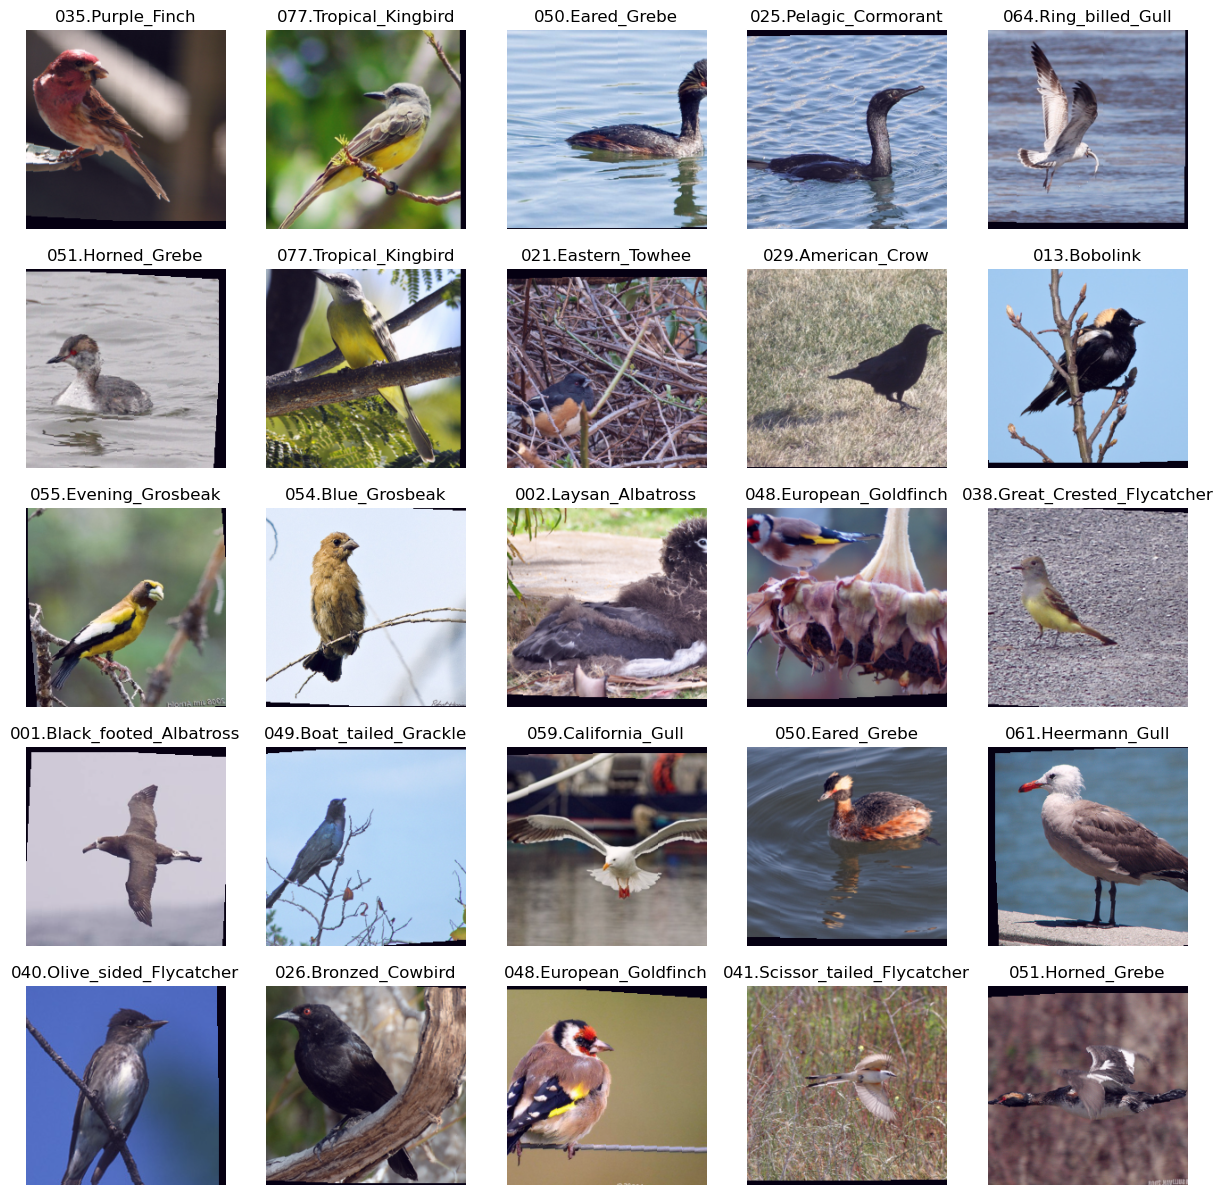

In [ ]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [ ]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

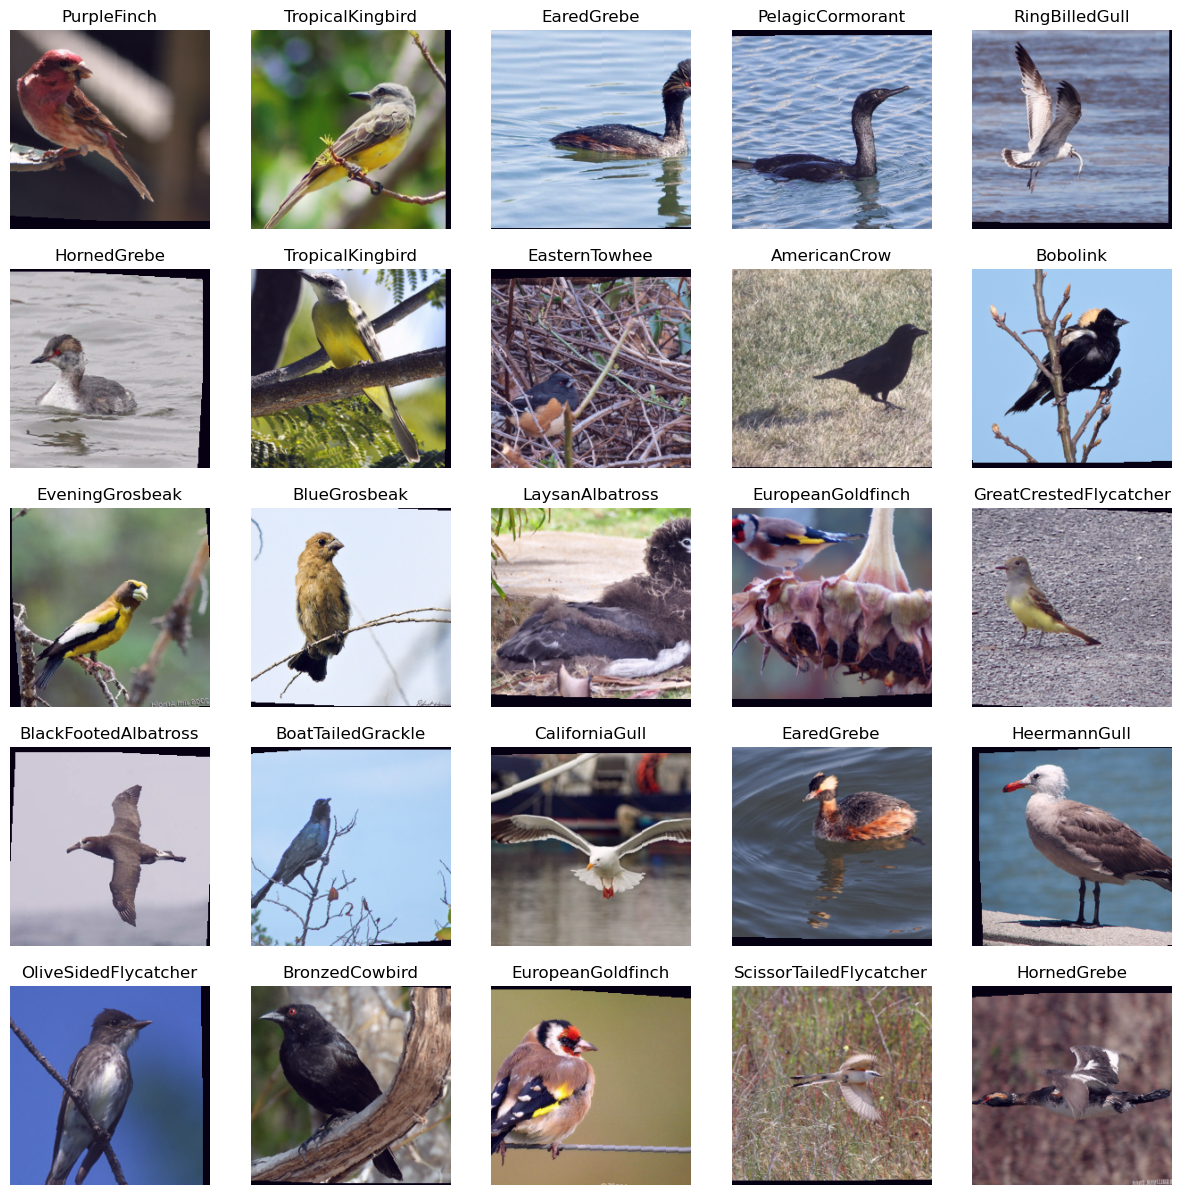

In [ ]:
test_data.classes = [format_label(c) for c in test_data.classes]

classes = test_data.classes

plot_images(images, labels, classes)

In [ ]:


import torch
import torchvision.models as models

# Load the resnet18 model
model = models.resnet18(pretrained=False)

/Users/mahekmaster/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mahekmaster/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')
     

The model has 11,689,512 trainable parameters


In [ ]:

import os
import torch

# Create a new directory
save_dir = "/Users/mahekmaster/Desktop/Mahek's Space/ConcordiaStudy/AIWINTER2023/AI_Project/2_Datasets/200 Bird Species_Dataset3"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
     

In [ ]:



lr = 0.01


optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:

# OnecycleLR Scheduler
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)
     

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
run_name = 'ResnetOptimization3' 
#wandb.init(project="AIProject2023", name = run_name, reinit=True) 

In [ ]:
import time

train_losses = []
train_acc_list = []
valid_losses = []
valid_acc_list = []

num_epochs = 10
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0
    
    # Training loop
    model.train()
    for images, labels in train_iterator:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        #print(" Loss ", loss)
        #print(" Item ", loss.item())
        #print(" Train Loss ", train_loss)
        #print(" Divided", train_loss / images.size(0))
        #wandb.log({'train_loss': loss.item()})
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        for images, labels in valid_iterator:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)
            #wandb.log({'valid_loss': loss.item()})
            _, predicted = torch.max(outputs.data, 1)
            valid_correct += (predicted == labels).sum().item()
            valid_total += labels.size(0)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), run_name)

    # Calculate metrics
    train_loss = train_loss / len(train_iterator.dataset)
    valid_loss = valid_loss / len(valid_iterator.dataset)
    train_accuracy = 100 * train_correct / train_total
    valid_accuracy = 100 * valid_correct / valid_total
    

    #wandb.log({'train_accuracy': train_accuracy})
    #wandb.log({'valid_accuracy': valid_accuracy})
    
    #append values
    
    train_losses.append(train_loss)
    train_acc_list.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_acc_list.append(valid_accuracy)
   
    
    # Print metrics
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {epoch+1} took {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s")
    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {valid_loss:.6f} | Val Accuracy: {valid_accuracy:.2f}%")

Epoch 1 took 5m 19s
Train Loss: 4.142716 | Train Accuracy: 5.05%
Val Loss: 3.973599 | Val Accuracy: 5.09%
Epoch 2 took 6m 12s
Train Loss: 3.417024 | Train Accuracy: 9.54%
Val Loss: 3.696133 | Val Accuracy: 12.73%
Epoch 3 took 6m 13s
Train Loss: 3.181328 | Train Accuracy: 14.22%
Val Loss: 3.358570 | Val Accuracy: 12.73%
Epoch 4 took 6m 11s
Train Loss: 2.986390 | Train Accuracy: 17.29%
Val Loss: 3.157823 | Val Accuracy: 12.00%
Epoch 5 took 6m 16s
Train Loss: 2.834988 | Train Accuracy: 20.12%
Val Loss: 2.944577 | Val Accuracy: 20.36%
Epoch 6 took 6m 19s
Train Loss: 2.664430 | Train Accuracy: 23.35%
Val Loss: 3.402998 | Val Accuracy: 17.09%
Epoch 7 took 6m 18s
Train Loss: 2.516327 | Train Accuracy: 26.95%
Val Loss: 2.982900 | Val Accuracy: 22.55%
Epoch 8 took 6m 21s
Train Loss: 2.378395 | Train Accuracy: 30.87%
Val Loss: 2.645728 | Val Accuracy: 23.27%
Epoch 9 took 6m 8s
Train Loss: 2.218540 | Train Accuracy: 34.83%
Val Loss: 2.786998 | Val Accuracy: 25.45%
Epoch 10 took 6m 11s
Train Loss:

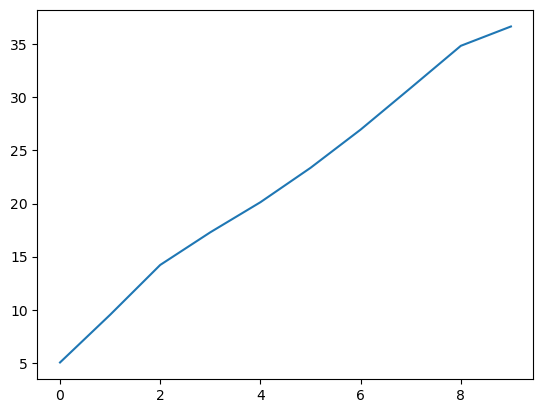

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(train_acc_list)), train_acc_list)

In [ ]:
# Testing loop
model.eval()
with torch.no_grad():
    total_test_loss = 0
    total_test_accuracy = 0
    total_test_count = 0
    for images, labels in test_iterator:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_test_accuracy += (predicted == labels).sum().item()
        total_test_count += images.size(0)

    average_test_loss = total_test_loss / total_test_count
    average_test_accuracy = total_test_accuracy / total_test_count

print(f"Test Loss: {average_test_loss:.4f}, Test Accuracy: {average_test_accuracy:.4f}")

Test Loss: 2.3400, Test Accuracy: 0.3000


In [ ]:
# Evaluation loop
model.eval()
with torch.no_grad():
    total_val_loss = 0
    total_val_accuracy = 0
    total_val_count = 0
    for images, labels in valid_iterator:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_val_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_val_accuracy += (predicted == labels).sum().item()
        total_val_count += images.size(0)

    average_val_loss = total_val_loss / total_val_count
    average_val_accuracy = total_val_accuracy / total_val_count

print(f"Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {average_val_accuracy:.4f}")

Validation Loss: 2.4877, Validation Accuracy: 0.2764
